In [10]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm






beta_rel=0.09405801936973575
gamma = 1.004453024014182

current=350e-3
length = 1.5 # m cooler length
r_beam=25*1e-3



T_perp = 0.1 # <E> [eV] = kb*T
T_l =  0.01 # <E> [eV]
B = 0.060 # T for LEIR
B_ratio=1e-10


mass0=193729.0248722061*1e6 #eV/c2
c=299792458.0
p0c = mass0*beta_rel*gamma #eV/c

length = 78.54370266 #m
T = length/(c*beta_rel)
s_per_turn = T



beta_x=9.5
beta_y=10.5
#emittance=14*1e-6

disp_x=0


arc=xt.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=disp_x,disp_x_1=disp_x,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )



Parameters: $I=2.4 A, B=0.060 T, \beta_x=10 m,\beta_y=4,D_x=0.12 m T_\perp=100meV,T_\parallel=1meV,\epsilon_{x}=35*1e-6,\epsilon_{y}=35*1e-6,dp/p=1e-3$

In [11]:
def emittance_6d(part):
    
        data = np.array([part.x,part.px,
                         part.y,part.py,
                         part.zeta,part.delta])
        
    
        cov00=np.cov(data)
    
        #det00 = np.sqrt((np.linalg.det(cov00)))*beta*gamma
        det00 = np.sqrt((np.linalg.det(cov00)))

                                 

        return det00

def emittance_4d(part):
    
        data = np.array([part.x,part.px,
                         part.y,part.py])
        
    
        cov00=np.cov(data)
    
        #det00 = np.sqrt((np.linalg.det(cov00)))*beta*gamma
        det00 = np.sqrt((np.linalg.det(cov00)))

                                 

        return det00

def emittance_x(part):
    
        data = np.array([part.x,part.px])
        
    
        cov00=np.cov(data)
    
        #det00 = np.sqrt((np.linalg.det(cov00)))*beta*gamma
        det00 = np.sqrt((np.linalg.det(cov00)))

        #print(det00)                         

        return det00

def emittance_y(part):
    
        data = np.array([part.y,part.py])
        
    
        cov00=np.cov(data)
    
        #det00 = np.sqrt((np.linalg.det(cov00)))*beta*gamma
        det00 = np.sqrt((np.linalg.det(cov00)))

        #print(det00)                         

        return det00



In [12]:
cooling_time=[]
num_particles=1000

beta_values=np.linspace(1, 500, num=4)

beta_values=[10]

for beta in (beta_values):
     
    beta_x=beta
    

    arc=xt.LinearTransferMatrix(Q_x=5.44, Q_y=5.42,
                                beta_x_0=beta_x, beta_x_1=beta_x,
                                beta_y_0=beta_y,  beta_y_1=beta_y,
                                alpha_x_0=0,   alpha_x_1=0,
                                alpha_y_0=0,   alpha_y_1=0,
                                disp_x_0=disp_x,disp_x_1=disp_x,
                                disp_y_0=0,    disp_y_1=0,
                                beta_s=1*1e40,
                                Q_s=0,
                                chroma_x=0.0, chroma_y=0)

    
    emittance=10*1e-6 #inital emittance
    
    sigma_x  = np.sqrt(beta_x*emittance)
    sigma_px = np.sqrt(emittance*1/beta_x)
    sigma_y  = np.sqrt(beta_y*emittance)
    sigma_py = np.sqrt(emittance*1/beta_y)
    sigma_p  = 2.5e-4


    delta = np.random.normal(loc=0.0, scale=sigma_p,  size=num_particles)
    x =     np.random.normal(loc=0.0, scale=sigma_x,  size=num_particles)+disp_x*delta
    px =    np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
    y =     np.random.normal(loc=0.0, scale=sigma_y,  size=num_particles)
    py =    np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

    particles = xp.Particles(
            
            mass0=mass0,
            p0c=p0c,
            x=x,
            px=px,
            y=y,
            py=py,
            delta=delta,
            zeta=0)


    cooler = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                            T_perp=T_perp,T_l=T_l,
                                            magnetic_field=B,B_ratio=B_ratio,
                                            Neutralisation_space_charge=1)

        

    num_turns=int(2*1e6)
    step=5

    # initialize arrays
    x, px, delta, action_x,action_y = [], [], [], [] ,[]

    beam_emittance=[]
    beam_emittance_x=[]
    beam_emittance_y=[]
    
    action_x_init = (particles.x**2/beta_x + beta_x*particles.px**2)
    action_x_init = np.percentile(action_x_init, 95)

    cutoff=0.1
    # loop over turns
    for i in tqdm(range(num_turns), desc='Cooling Progress', leave=False):
        if i % step == 0:
            # calculate action in horizontal plane
            action_x_temp = (particles.x**2/beta_x + beta_x*particles.px**2)
            action_x_temp = np.percentile(action_x_temp, 95)
            action_x.append(action_x_temp)

            action_y_temp = (particles.y**2/beta_y + beta_y*particles.py**2)
            action_y_temp = np.percentile(action_y_temp, 95)
            action_y.append(action_y_temp)

            beam_emittance_temp=emittance_4d(particles)    
            beam_emittance.append(beam_emittance_temp)

            beam_emittance_x.append(emittance_x(particles))
            beam_emittance_y.append(emittance_y(particles))

            # if action_x_temp < cutoff*action_x_init:
            #             cooling_time.append(i*s_per_turn)
            #             break
        # track particle
        arc.track(particles)
        cooler.track(particles)
    
   
    # if action_x_temp >= cutoff*action_x_init:
    #     cooling_time.append(num_turns * s_per_turn)  # Append default value if cooling condition is not met




            

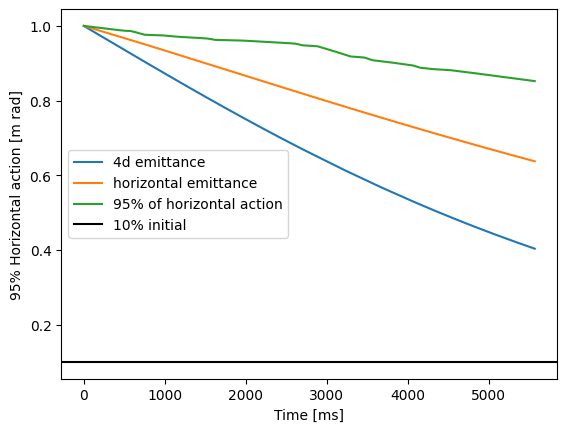

In [13]:
time = np.arange(0, num_turns, step) * s_per_turn*1000   
plt.figure()
plt.plot(time,beam_emittance/beam_emittance[0]    ,label='4d emittance')
plt.plot(time,beam_emittance_x/beam_emittance_x[0],label='horizontal emittance')
plt.plot(time,action_x/action_x[0]                ,label='95% of horizontal action')
plt.axhline(0.1,color='black',label='10% initial')
plt.xlabel('Time [ms]')
plt.ylabel('95% Horizontal action [m rad]')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

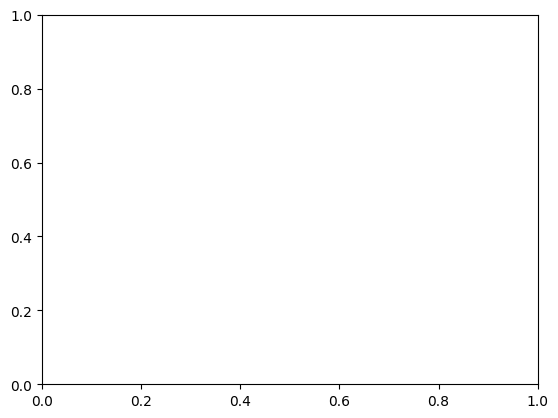

In [14]:
# Plot the horizontal action versus time
plt.figure()
plt.plot(beta_values,cooling_time)
plt.xlabel(r'$\beta_x$ [m]')
plt.ylabel('Time [s]')
plt.title('AD (300MeV): Beta vs Cooling time')
plt.legend()
plt.ticklabel_format(useOffset=False)